# Fastai 2 medical imaging

BentoML is an open-source framework for machine learning **model serving**, aiming to **bridge the gap between Data Science and DevOps.**
 
Data Scientists can easily package their models trained with any ML framework using BentoMl and reproduce the model for serving in production. BentoML helps with managing packaged models in the BentoML format, and allows DevOps to deploy them as online API serving endpoints or offline batch inference jobs, on any cloud platform.

Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This notebook demonstrates using BentoML to deploy Fastai2 medical image classification model as API server.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=fast-ai&ea=fast-ai2-medical-imaging&dt=fast-ai2-medical-imaging)


In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -U -q bentoml fastai2>=0.0.30 pydicom>=1.4.0 nbdev>=1.0.0 kornia>=0.4.0

In [9]:
from fastai2.data.block import DataBlock, CategoryBlock
from fastai2.data.external import untar_data, URLs
from fastai2.data.transforms import RandomSplitter
from fastai2.metrics import accuracy
from fastai2.vision.data import ImageBlock
from fastai2.medical.imaging import get_dicom_files, dcmread, PILDicom
from fastai2.vision.augment import aug_transforms
from fastai2.vision.learner import cnn_learner
from fastai2.vision.models import resnet34

import pydicom

import pandas as pd

import torch
import bentoml.utils.cloudpickle as cloudpickle

In [10]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

In [11]:
items = get_dicom_files(pneumothorax_source/f"train/")
trn, val = RandomSplitter()(items)

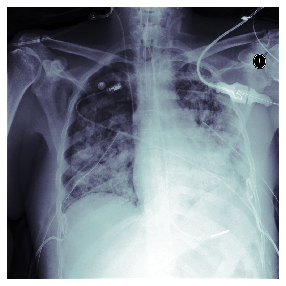

In [12]:
patient = 3
xray_sample = dcmread(items[patient])
xray_sample.show()

In [13]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [14]:
%%writefile datablock_utils.py

from fastai2.data.external import untar_data, URLs

pneumothorax_source = untar_data(URLs.SIIM_SMALL)

def get_x(x):
    return pneumothorax_source/f"{x[0]}"

def get_y(x):
    return x[1]

Overwriting datablock_utils.py


In [15]:
from datablock_utils import get_x, get_y

pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   #get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   #get_y=lambda x:x[1],
                   get_x=get_x,
                   get_y=get_y,
                   batch_tfms=aug_transforms(size=224))

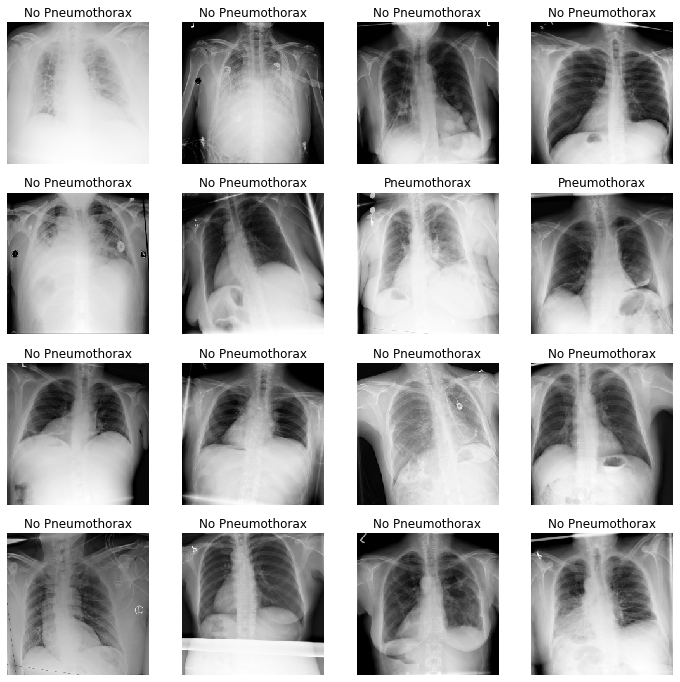

In [16]:
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

In [17]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.437326,2.478858,0.400000,01:06


In [18]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")


in learner /Users/bozhaoyu/.fastai/data/siim_small/train/Pneumothorax/000004.dcm
<bound method DataLoaders.test_dl of <fastai2.data.core.DataLoaders object at 0x7f807bd5fbe0>>
in learner <fastai2.data.core.TfmdDL object at 0x7f807bdbe7b8>


('Pneumothorax', tensor(1), tensor([0.0020, 0.9980]))

In [19]:
%%writefile medical_image_service.py
from bentoml.frameworks.fastai2 import Fastai2ModelArtifact
from bentoml.adapters import FileInput
from fastcore.utils import tuplify, detuplify

import bentoml
import datablock_utils

@bentoml.artifacts([Fastai2ModelArtifact('learner')])
@bentoml.env(pip_packages=['torch', 'fastai2'])
class FastaiMedicalImagingService(bentoml.BentoService):

    @bentoml.api(input=FileInput())
    def predict(self, files):
        files = [i.read() for i in files]
        dl = self.artifacts.learner.dls.test_dl(files, rm_type_tfms=None, num_workers=0)
        inp, preds, _, dec_preds = self.artifacts.learner.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.artifacts.learner.dls, 'n_inp', -1)
        inp = (inp,)
        dec_list = self.artifacts.learner.dls.decode_batch(inp + tuplify(dec_preds))
        res = []
        for dec in dec_list:
            dec_inp, dec_targ = map(detuplify, [dec[:i], dec[i:]])
            res.append(dec_targ)
        return res

Overwriting medical_image_service.py


In [20]:
import bentoml

from fastcore.utils import remove_patches_path
from medical_image_service import FastaiMedicalImagingService

print(learn.metrics)
learn.metrics = []

svc = FastaiMedicalImagingService()
svc.pack('learner', learn)

# Fastcore modify Pathlib module from python, need to remove the patch in order to save
with remove_patches_path():
    saved_path = svc.save()

(#1) [<fastai2.learner.AvgMetric object at 0x7f807bdbe4a8>]
[2020-08-11 13:36:49,468] WARNING - BentoML by default does not include spacy and torchvision package when using Fastai2ModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
[2020-08-11 13:36:50,676] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..


no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.8.4/bentoml/_version.py
set BentoML-0.8.4/bentoml/_version.py to '0.8.4'
[2020-08-11 13:36:54,568] INFO - BentoService bundle 'FastaiMedicalImagingService:20200811133650_01D85E' saved to: /Users/bozhaoyu/bentoml/repository/FastaiMedicalImagingService/20200811133650_01D85E


In [25]:
bento_tag = f'{svc.name}:{svc.version}'

## REST API Model Serving

To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [27]:
!bentoml serve FastaiMedicalImagingService:latest

[2020-08-11 13:46:39,462] INFO - Getting latest version FastaiMedicalImagingService:20200811133650_01D85E
[2020-08-11 13:46:39,463] INFO - Starting BentoML API server in development mode..
[2020-08-11 13:46:42,621] WARNING - BentoML by default does not include spacy and torchvision package when using Fastai2ModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
 * Serving Flask app "FastaiMedicalImagingService" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
^C


If you are running this notebook from Google Colab, you can start the dev server with --run-with-ngrok option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com):

In [ ]:
!bentoml serve FastaiMedicalImagingService:atest --run-with-ngrok

### Send prediction request to the REST API server

Go visit http://127.0.0.1:5000/ from your browser, click /predict -> Try it out -> Choose File -> Execute to sumbit an image from your computer

or Using `curl` request:

```
curl -X POST "http://localhost:5000/predict" \
  -F image=@000004.dcm
```

### Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [ ]:
!bentoml containerize FastaiMedicalImagingService:latest

In [ ]:
!docker run --rm -p 5000:5000 fastaimedicalimagingservice

### Launch inference job from CLI


BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [1]:
!bentoml run FastaiMedicalImagingService:latest predict \
    --input /Users/bozhaoyu/.fastai/data/siim_small/train/Pneumothorax/000004.dcm

[2020-08-11 14:05:48,424] INFO - Getting latest version FastaiMedicalImagingService:20200811133650_01D85E
[2020-08-11 14:05:52,012] WARNING - BentoML by default does not include spacy and torchvision package when using Fastai2ModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
Pneumothorax                                     


### Load saved BentoService

bentoml.load is the API for loading a BentoML packaged model in python:

In [ ]:
from bentoml import load


loaded_svc = load(saved_path)

print(loaded_svc.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm"))

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)